# LAPW project

This project is adapted from Thijssen and uses data taken from Energy Band Structure of Copper by Glenn A. Burdick.

This is currently broken, I believe that its an issue with units.

Stuff used:
- Thijssen book
- Wave Functions and Energy Levels for Cu+ as Found by the Slater Approximation to the Hartree-Fock Equations paper by Pratt
- Energy Band Structure of Copper by Glenn A. Burdick
- Use of energy derivative of the radial solution in an
augmented plane wave method: application to
copper by Koelling and Arbman
- APW code from: https://github.com/aromanro/APW/tree/master


In [172]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import integrate
import functools



In [173]:
#constants
a = 6.822
vol = 3*(a**3)/4

#simulation parameters
l_max = 7
nLim = 2

#recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [174]:
rs = np.linspace(0,2.430905,num=10**4)
h = rs[1] - rs[0]
h2 = h**2
h12 = h2/12
r_max = rs[-2]

def V(r):
    term1 = 29.*np.exp(-2.3151241717834*(r**0.81266614122432) + (2.1984250222603E-2)*(r**4.2246376280056))
    term2 = -0.15595606773483*r - (3.1350051440417E-3)*r**2 + (5.1895222293006E-2)*r**3 - (2.8027608685637E-2)*r**4
    return term1 + term2


E_v = 0
#explain where these come from, are these required to get good results

#empty global variables
RMax = np.empty(l_max)
RDashMax = np.empty(l_max)
RDotMax = np.empty(l_max)
RDotDashMax = np.empty(l_max)
N = np.empty(l_max)

In [175]:
def getAllUs(l,E):
    def f(r):
        if r == 0:
            return 0
        return l*(l+1)/r**2 + 2*(V(r) - E)
    
    us = np.empty(len(rs))
    us[0] = 0
    us[1] = rs[1]**(l+1)*(1-29*rs[1]/(l+1))

    fn = f(rs[1])
    w0 = 0
    w1 = (1 - h12*fn)*us[1]
    
    for n in range(1,len(rs)-1):
        w2 = 2*w1 - w0 + h2*us[n]*fn
        fn1 = f(rs[n+1])
        us[n+1] = w2/(1 - h12*fn1)
        w0 = w1
        w1 = w2
        fn = fn1

    return us/np.sqrt(integrate.simpson(us**2,x=rs))



In [176]:
def getuDots(l,usR):
    def f(r):
        if r == 0:
            return 0
        return l*(l+1)/r**2 + 2*(V(r) - E_v)
    

    us = np.empty(len(rs))
    us[0] = 0
    us[1] = rs[1]**(l+1)*(1-29*rs[1]/(l+1))

    fn = f(rs[1])
    ws0 = 0
    ws1 = us[1]*(1 - h12*fn) + 2*h12*usR[1]

    
    for n in range(1,len(rs)-1):
        ws2 = 2*ws1 - ws0 + h2*(us[n]*fn - 2*usR[n])
        fn1 = f(rs[n+1])
        us[n+1] = (ws2 - 2*h12*usR[n+1])/(1 - h12*fn1)
        ws0 = ws1
        ws1 = ws2
        fn = fn1

    #orthogonalise
    homoConstant = -integrate.simpson(us*usR,x=rs)/integrate.simpson(usR**2,x=rs)

    return homoConstant*usR + us

def test(l,uDots,us):
    print(f"---{l}---")
    for n in range(1,len(rs)-1):
        dev = abs(((l*(l+1)/(2*rs[n]**2) + V(rs[n]) - E_v)*uDots[n] - (uDots[n+1] + uDots[n-1] - 2*uDots[n])/(2*h**2)) - us[n])
        print(f"{n}: {dev}")


In [177]:
#find global variables
for l in range(l_max):
    #use logarithmic derivative
    us = getAllUs(l,E_v)
    RMax[l] = us[-2]/r_max
    RDashMax[l] = us[-2]*np.log(us[-1]/us[-3])/(2*h*r_max) - us[-2]/(r_max**2) #log derivative
    uDots = getuDots(l,us)/2 #?
    RDotMax[l] = uDots[-2]/r_max
    RDotDashMax[l] = uDots[-2]*np.log(uDots[-1]/uDots[-3])/(2*h*r_max) - uDots[-2]/(r_max**2)

    #print(uDots -(getAllUs(l,E_v+0.0001) - getAllUs(l,E_v-0.0001))/0.0002)
    print((r_max**2)*(RDashMax[l]*RDotMax[l] - RMax[l]*RDotDashMax[l])) 
    #print(simpsons(uDots*us))
    #if l == l_max-1:
    #    test(l,uDots,us)

    N[l] = integrate.simpson(uDots**2,x=rs)

0.9993921191143649
0.9993125571813241
0.9991801030648207
0.9990187474925007
0.9988421466324976
0.9986572378465944
0.9984675449652113


In [178]:
def getE(k): 
    #define functions required to calcuate matricies
    def a(l,q):
        qMag = np.linalg.norm(q)
        return sp.spherical_jn(l,r_max*qMag,derivative=True)*qMag*RDotMax[l] - sp.spherical_jn(l,r_max*qMag)*RDotDashMax[l]
        
    def b(l,q):
        qMag = np.linalg.norm(q) 
        return sp.spherical_jn(l,r_max*qMag)*RDashMax[l] - sp.spherical_jn(l,r_max*qMag,derivative=True)*qMag*RMax[l]
    
    @functools.lru_cache(maxsize=len(Ks)**2)
    def U(KMag):
        if KMag == 0:
            return 1 - 4*np.pi*(r_max**3)/(3*vol)
        return -4*np.pi*(r_max**2)*sp.spherical_jn(1,KMag*r_max)/(KMag*vol)

    #calculate matricies
    qs = [k + K for K in Ks]

    S = np.empty([len(Ks),len(Ks)])
    H = np.empty([len(Ks),len(Ks)])

    for i in range(len(qs)):
        for j in range(i+1):
            Uij = U(np.linalg.norm(qs[i] - qs[j]))
            qi = np.linalg.norm(qs[i])
            qj = np.linalg.norm(qs[j])
            cosThetaij = np.dot(qs[i],qs[j])/(qi*qj)
            S[i,j] = Uij
            H[i,j] = ((qi**2 + qj**2)/4 - E_v)*Uij
            
            for l in range(l_max):
                aiaj = a(l,qs[i])*a(l,qs[j])
                bij = b(l,qs[i])*b(l,qs[j])
                lij = sp.eval_legendre(l,cosThetaij)
                S[i,j] += 4*np.pi*(2*l + 1)*lij*(aiaj + bij*N[l])/(vol*(r_max**4))
                H[i,j] += 2*np.pi*(2*l + 1)*lij*(aiaj + bij)/(vol*(r_max**4))
            S[j,i] = S[i,j]
            H[j,i] = H[i,j]
    
    return linalg.eigvalsh(H,S)


In [179]:
#finds the energies for a list of k's
ks2 = [2*np.pi*np.array([i/20,0,0])/a for i in range(1,21)]
Es2 = np.empty([len(ks2),20])

for i,k in enumerate(ks2):
    print(i)
    sol = getE(k)
    for j in range(20):
        Es2[i,j] = sol[j]


0


TypeError: unhashable type: 'numpy.ndarray'

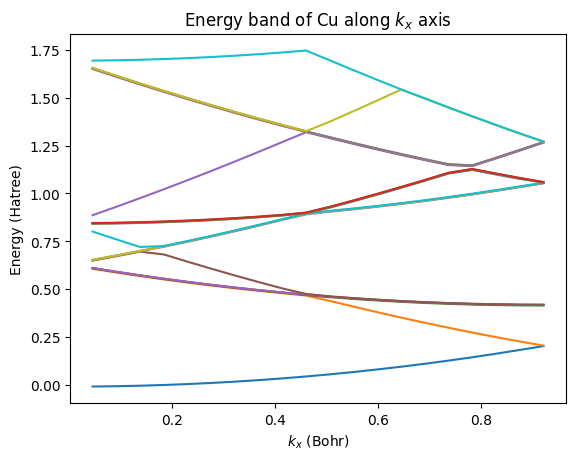

In [ ]:
#Graphs 
kx = list(map(lambda k: k[0],ks2))

for i in range(20):
    plt.plot(kx,Es2[:,i]/2)
plt.title(r"Energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hatree)")
plt.show()